In [1]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from config import api_key
import json
import requests
import scipy.stats as stats
from scipy.stats import linregress
from pprint import pprint

In [2]:
# Read in raw data csv file and create dataframe
data = 'resources/raw_data.csv'
data_df = pd.read_csv(data)
data_df.head(10)

state  year  age18longgunpossess  age18longgunsale  \
0      Alabama  1991                    0                 0   
1       Alaska  1991                    0                 0   
2      Arizona  1991                    0                 0   
3     Arkansas  1991                    0                 0   
4   California  1991                    0                 1   
5     Colorado  1991                    0                 0   
6  Connecticut  1991                    0                 0   
7     Delaware  1991                    0                 0   
8      Florida  1991                    0                 0   
9      Georgia  1991                    0                 0   

   age21handgunpossess  age21handgunsale  age21longgunpossess  \
0                    0                 0                    0   
1                    0                 0                    0   
2                    0                 0                    0   
3                    0                 0                    0   
4                    0                 1                    0   
5                    0                 0                    0   
6                    0                 0                    0   
7                    0                 1                    0   
8                    0                 0                    0   
9                    0                 1                    0   

   age21longgunsale  age21longgunsaled  alcoholism  ...  universal  \
0                 0                  0           1  ...          0   
1                 0                  0           0  ...          0   
2                 0                  0           0  ...          0   
3                 0                  0           0  ...          0   
4                 0                  0           1  ...          1   
5                 0                  0           0  ...          0   
6                 0                  0           0  ...          0   
7                 0                  0           0  ...          0   
8                 0                  0           0  ...          0   
9                 0                  0           0  ...          0   

   universalh  universalpermit  universalpermith  violent  violenth  \
0           0                0                 0        0         0   
1           0                0                 0        0         0   
2           0                0                 0        0         0   
3           0                0                 0        0         0   
4           1                1                 1        1         1   
5           0                0                 0        0         0   
6           0                0                 0        0         0   
7           0                0                 0        0         0   
8           0                0                 0        0         0   
9           0                0                 0        0         0   

   violentpartial  waiting  waitingh  lawtotal  
0               0        0         1        15  
1               0        0         0        10  
2               0        0         0        12  
3               0        0         0        15  
4               1        1         1        58  
5               0        0         0         9  
6               0        0         0        27  
7               1        0         0        12  
8               0        0         0        18  
9               0        0         0        12  

[10 rows x 136 columns]

In [3]:
# Create new dataframe consisting of only the state, year, and lawtotal
data_df2 = data_df.loc[:, ['state', 'year', 'lawtotal']]
data_df2.tail(10)

state  year  lawtotal
1340   South Dakota  2017         5
1341      Tennessee  2017        22
1342          Texas  2017        18
1343           Utah  2017        13
1344        Vermont  2017         6
1345       Virginia  2017        13
1346     Washington  2017        43
1347  West Virginia  2017        21
1348      Wisconsin  2017        23
1349        Wyoming  2017         9

In [4]:
# Create combined list of all background check laws
background_df = data_df[['backgroundpurge','gunshow','gunshowh','mentalhealth','statechecks','statechecksh',
                         'threedaylimit','universal','universalh','universalpermit','universalpermith']]
background_df.head(10)

backgroundpurge  gunshow  gunshowh  mentalhealth  statechecks  \
0                0        0         0             0            0   
1                0        0         0             0            0   
2                0        0         0             0            0   
3                0        0         0             0            0   
4                1        1         1             1            1   
5                0        0         0             0            0   
6                0        0         0             0            0   
7                0        0         0             0            0   
8                0        0         0             0            0   
9                0        0         0             0            0   

   statechecksh  threedaylimit  universal  universalh  universalpermit  \
0             0              0          0           0                0   
1             0              0          0           0                0   
2             0              0          0           0                0   
3             0              0          0           0                0   
4             1              1          1           1                1   
5             0              0          0           0                0   
6             0              0          0           0                0   
7             0              0          0           0                0   
8             0              0          0           0                0   
9             0              0          0           0                0   

   universalpermith  
0                 0  
1                 0  
2                 0  
3                 0  
4                 1  
5                 0  
6                 0  
7                 0  
8                 0  
9                 0

In [5]:
# Calculate the total number of background check laws per state per year
# Loop through the rows summing each state that has a law
background = []
for index, row in background_df.iterrows():
    #background_count = 0
    background.append(row.sum())

data_df2['backgroundchecktotal'] = background
data_df2 = data_df2[['state', 'year', 'backgroundchecktotal', 'lawtotal']]
data_df2.head(10)

state  year  backgroundchecktotal  lawtotal
0      Alabama  1991                     0        15
1       Alaska  1991                     0        10
2      Arizona  1991                     0        12
3     Arkansas  1991                     0        15
4   California  1991                    11        58
5     Colorado  1991                     0         9
6  Connecticut  1991                     0        27
7     Delaware  1991                     0        12
8      Florida  1991                     0        18
9      Georgia  1991                     0        12

In [6]:
# Extract California and Texas data from data_df2
data_df3 = data_df2.loc[data_df2['state'].isin(['California', 'Texas'])].sort_values(['state', 'year'])
data_df3.head(10)

state  year  backgroundchecktotal  lawtotal
4    California  1991                    11        58
54   California  1992                    11        57
104  California  1993                    11        57
154  California  1994                    11        69
204  California  1995                    11        69
254  California  1996                    11        69
304  California  1997                    11        70
354  California  1998                    11        70
404  California  1999                    11        71
454  California  2000                    11        85

In [7]:
# Set up url, and get request and response for mass shootings api
url = "https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-mass-shootings-1982-2017&q=&rows=150&facet=state&facet=date&facet=type"
response = requests.get(url).json()

# Print response from api
print(json.dumps(response, indent = 4, sort_keys = True))

{
    "error": "Unknown dataset: us-mass-shootings-1982-2017"
}


In [8]:
# Check keys from response of api
response.keys()

dict_keys(['nhits', 'parameters', 'records', 'facet_groups'])

In [9]:
# Print 
print(json.dumps(response['records'], indent = 4, sort_keys = True))

[
    {
        "datasetid": "us-mass-shootings-1982-2017",
        "fields": {
            "case": "R.E. Phelon Company shooting",
            "coordinates": [
                33.5598586,
                -81.721952
            ],
            "date": "1997-09-15",
            "fatalities": 4,
            "gender": "Male",
            "injured": 3,
            "location": "Aiken",
            "mental_health_details": "An ex-con, he had been freed from prison, although he displayed violent tendencies.",
            "mental_health_sources": "http://chronicle.augusta.com/stories/1997/09/18/met_214833.shtml",
            "prior_signs_of_mental_health_issues": "No",
            "race": "Black",
            "sources": "http://www.vpc.org/studies/wgun970915.htm; http://chronicle.augusta.com/stories/1997/09/18/met_214833.shtml",
            "state": "SouthCarolina",
            "summary": "Ex-con Hastings Arthur Wise, 43, opened fire at the R.E. Phelon Company in retaliation for being fired aft

In [10]:
# Print a test
response['records'][0]['fields']['state']

'SouthCarolina'

In [11]:
# Create lists to use for loop and dataframe
states = ['Texas', 'California']
state = []
date = []
total_victims = []

# loop throug api response to get data
for i, item in enumerate(response['records']):
    
    # Error handling
    try:
        if item['fields']['state'] in states:
            state.append(item['fields']['state'])
            date.append(item['fields']['date'])
            total_victims.append(item['fields']['total_victims'])
            
    except (KeyError, IndexError):
        print('')

In [8]:
# Create dictionary for mass shootings
mass_shooting_dict = {
    'state': state,
    'date': date,
    'total victims': total_victims
}

# Create mass shootings dataframe, convert date column to datetime datatype, and display date in years
mass_shooting_df = pd.DataFrame(mass_shooting_dict).sort_values(['state', 'date'])
mass_shooting_df['year'] = pd.to_datetime(mass_shooting_df['date']).dt.year
mass_shooting_df2 = mass_shooting_df[['state', 'year', 'total victims']]
mass_shooting_df2

NameError: name 'state' is not defined

In [9]:
# Read in California and Texas deaths csv files in to dataframes and merge them
cal_death = 'resources/cal_deaths_1999-2018.csv'
tex_death = 'resources/tex_deaths_1999-2018.csv'
cal_death_df = pd.read_csv(cal_death)
tex_death_df = pd.read_csv(tex_death)
# death_df = pd.concat([cal_death_df, tex_death_df])
# death_df
cal_death_df.tail()

State  Year  Deaths  Population  Crude Rate
15  California  2014    2838    38802500         7.3
16  California  2015    2984    39144818         7.6
17  California  2016    3098    39250017         7.9
18  California  2017    3083    39536653         7.8
19  California  2018    2938    39557045         7.4

In [10]:
# Create variables for California and Texas populations and deaths from 1999-2018
cal_pop = cal_death_df['Population'].drop(cal_death_df['Population'].index[-1])
tex_pop = tex_death_df['Population'].drop(tex_death_df['Population'].index[-1])
cal_deaths = cal_death_df['Deaths'].drop(cal_death_df['Deaths'].index[-1])
tex_deaths = tex_death_df['Deaths'].drop(tex_death_df['Deaths'].index[-1])
cal_death_rate = cal_death_df['Crude Rate'].drop(cal_death_df['Crude Rate'].index[-1])
tex_death_rate = tex_death_df['Crude Rate'].drop(tex_death_df['Crude Rate'].index[-1])
pop_years = cal_death_df['Year'].drop(cal_death_df['Year'].index[-1])

In [11]:
# Create variables for California mass shootings
cal_mass = mass_shooting_df2.loc[mass_shooting_df2['state'].isin(['California'])]
x_cal_mass = cal_mass['year']
y_cal_mass = cal_mass['total victims']

NameError: name 'mass_shooting_df2' is not defined

In [12]:
# Create variables for Texas mass shootings
tex_mass = mass_shooting_df2.loc[mass_shooting_df2['state'].isin(['Texas'])]
x_tex_mass = tex_mass['year']
y_tex_mass = tex_mass['total victims']

NameError: name 'mass_shooting_df2' is not defined

In [13]:
# Create variables for California background checks and law total plots
cal = data_df3.loc[data_df3['state'].isin(['California'])]
x_cal_yr = cal['year'].drop(cal['year'].index[[0, 1, 2, 3, 4, 5, 6, 7]])
y_cal_bgck = cal['backgroundchecktotal'].drop(cal['backgroundchecktotal'].index[[0, 1, 2, 3, 4, 5, 6, 7]])
y_cal_laws = cal['lawtotal'].drop(cal['lawtotal'].index[[0, 1, 2, 3, 4, 5, 6, 7]])

In [198]:
# Create variables for Texas background checks and law total plots
tex = data_df3.loc[data_df3['state'].isin(['Texas'])]
x_tex_yr = tex['year'].drop(tex['year'].index[[0, 1, 2, 3, 4, 5, 6, 7]])
y_tex_bgck = tex['backgroundchecktotal'].drop(tex['backgroundchecktotal'].index[[0, 1, 2, 3, 4, 5, 6, 7]])
y_tex_laws = tex['lawtotal'].drop(tex['lawtotal'].index[[0, 1, 2, 3, 4, 5, 6, 7]])

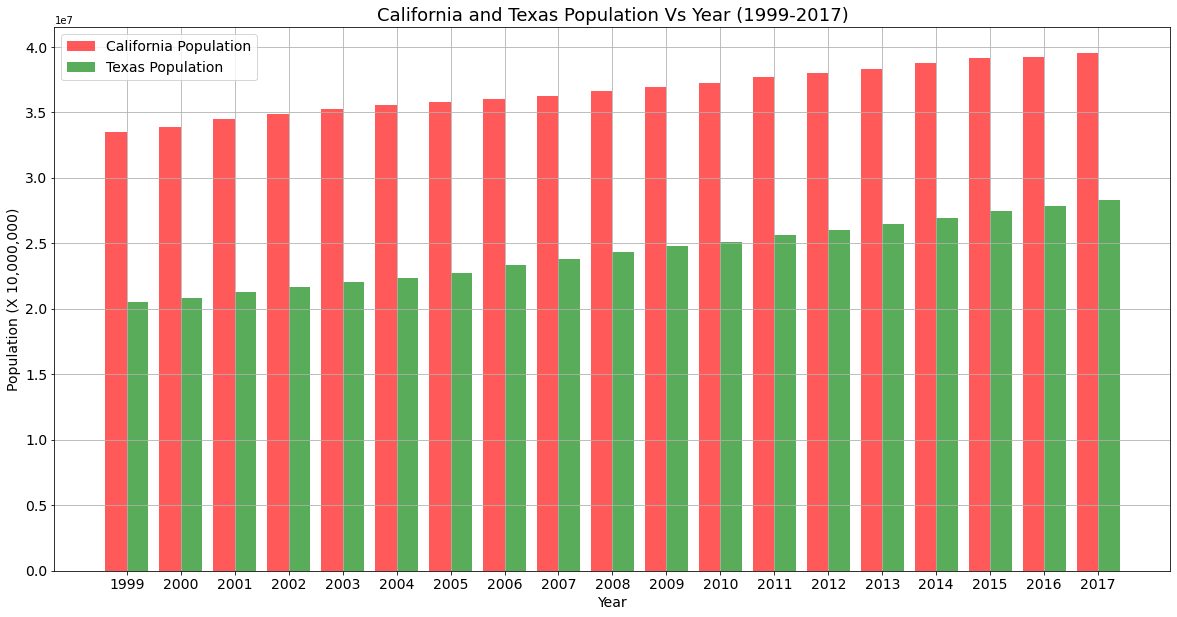

In [197]:
# Plot California and Texas populations from 1999-2018
plt.figure(figsize = (20, 10))
plt.bar(pop_years - 0.2, cal_pop, width = 0.4, color = "red", alpha = 0.65, label = 'California Population')
plt.bar(pop_years + 0.2, tex_pop, width = 0.4, color = "green", alpha = 0.65, label = 'Texas Population')
plt.title('California and Texas Population Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Population (X 10,000,000)', fontsize = 14)
plt.xticks(np.arange(1999, 2018, step = 1), fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()
plt.savefig('output_data/cal_tex_pop.png')
plt.show()

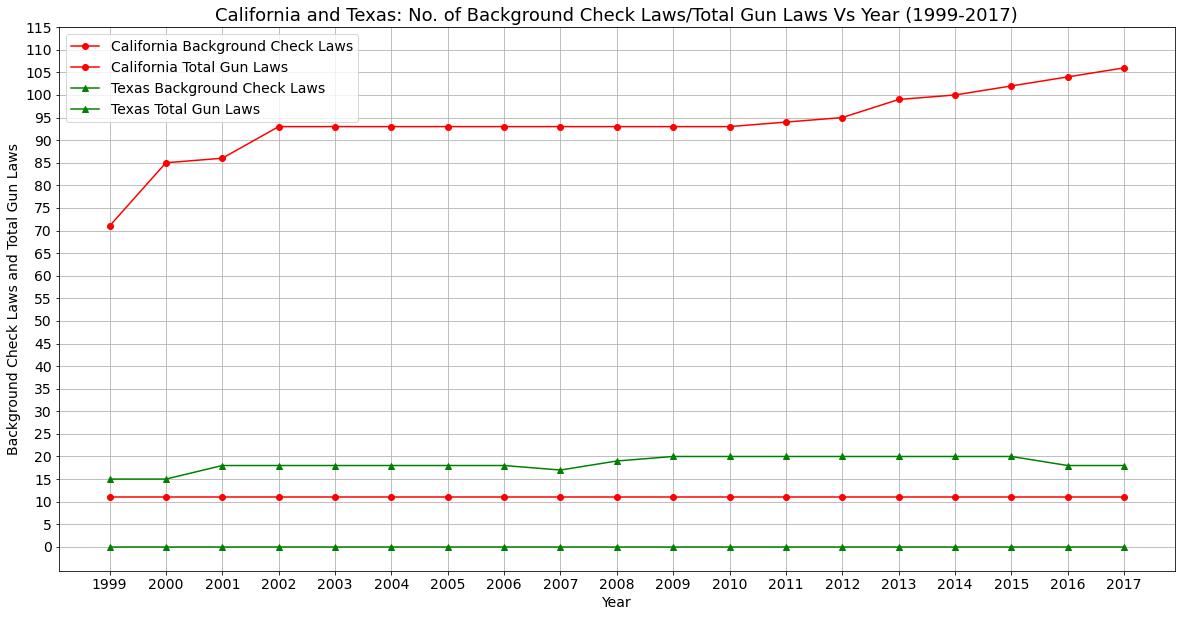

In [194]:
# Plot background check laws total and gun law total vs year for California and Texas
plt.figure(figsize = (20, 10))
plt.plot(x_cal_yr, y_cal_bgck, marker = 'o', color = "red", label = 'California Background Check Laws')
plt.plot(x_cal_yr, y_cal_laws, marker = 'o', color = "red", label = 'California Total Gun Laws')
plt.plot(x_tex_yr, y_tex_bgck, marker = '^', color = "green", label = 'Texas Background Check Laws')
plt.plot(x_tex_yr, y_tex_laws, marker = '^', color = "green", label = 'Texas Total Gun Laws')
plt.title('California and Texas: No. of Background Check Laws/Total Gun Laws Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Background Check Laws and Total Gun Laws', fontsize = 14)
plt.xticks(np.arange(1999, 2018, step = 1), fontsize = 14)
plt.yticks(np.arange(0, 120, step = 5), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()
plt.savefig('output_data/caltex_gun_laws.png')
plt.show()

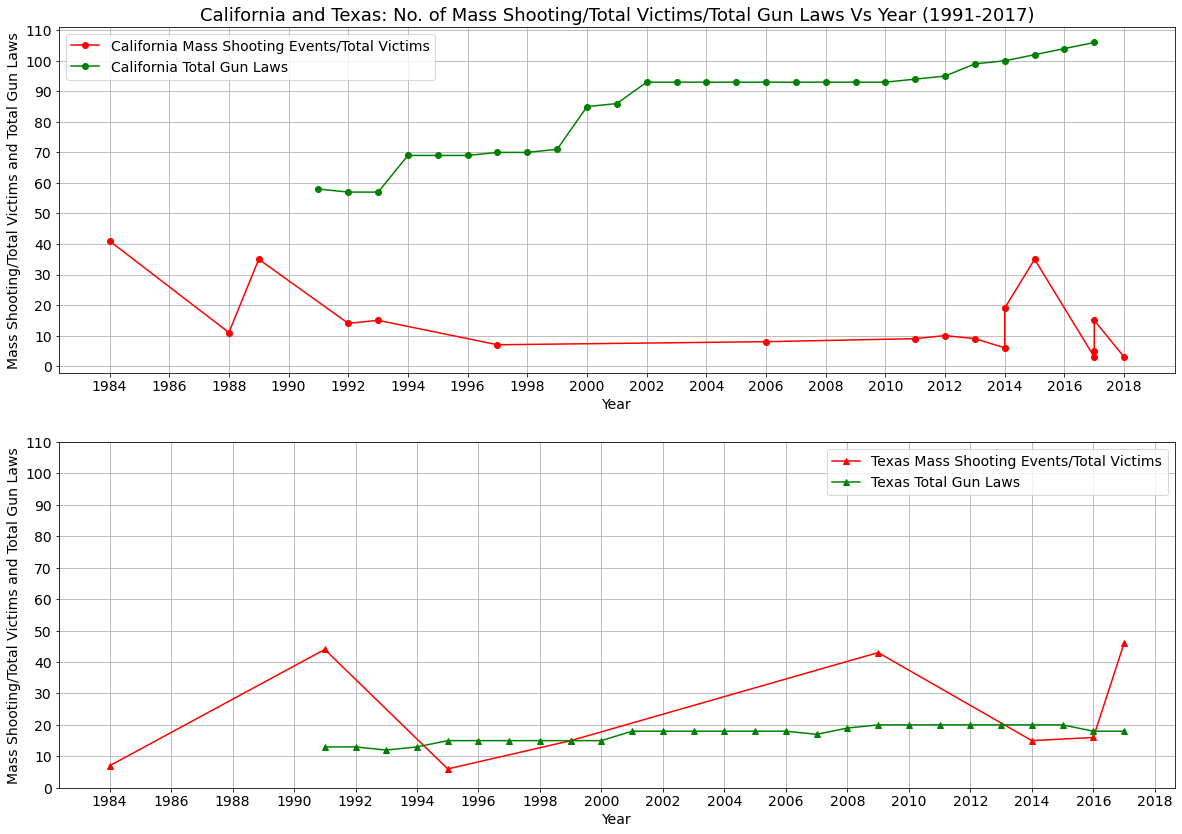

In [143]:
# Plot gun law total and mass shooting vs year for California
plt.figure(figsize = (20, 14))

plt.subplot(2, 1, 1)
plt.plot(x_cal_mass, y_cal_mass, marker = 'o', color = "red", label = 'California Mass Shooting Events/Total Victims')
plt.plot(x_cal_yr, y_cal_laws, marker = 'o', color = "green", label = 'California Total Gun Laws')
plt.title('California and Texas: No. of Mass Shooting/Total Victims/Total Gun Laws Vs Year (1991-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Mass Shooting/Total Victims and Total Gun Laws', fontsize = 14)
plt.xticks(np.arange(1984, 2020, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 120, step = 10), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(x_tex_mass, y_tex_mass, marker = '^', color = "red", label = 'Texas Mass Shooting Events/Total Victims')
plt.plot(x_cal_yr, y_tex_laws, marker = '^', color = "green", label = 'Texas Total Gun Laws')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Mass Shooting/Total Victims and Total Gun Laws', fontsize = 14)
#plt.xlim([1990, 2018])
plt.xticks(np.arange(1984, 2020, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 120, step = 10), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()
plt.savefig('output_data/caltex_mass_shooting.png')
plt.show()

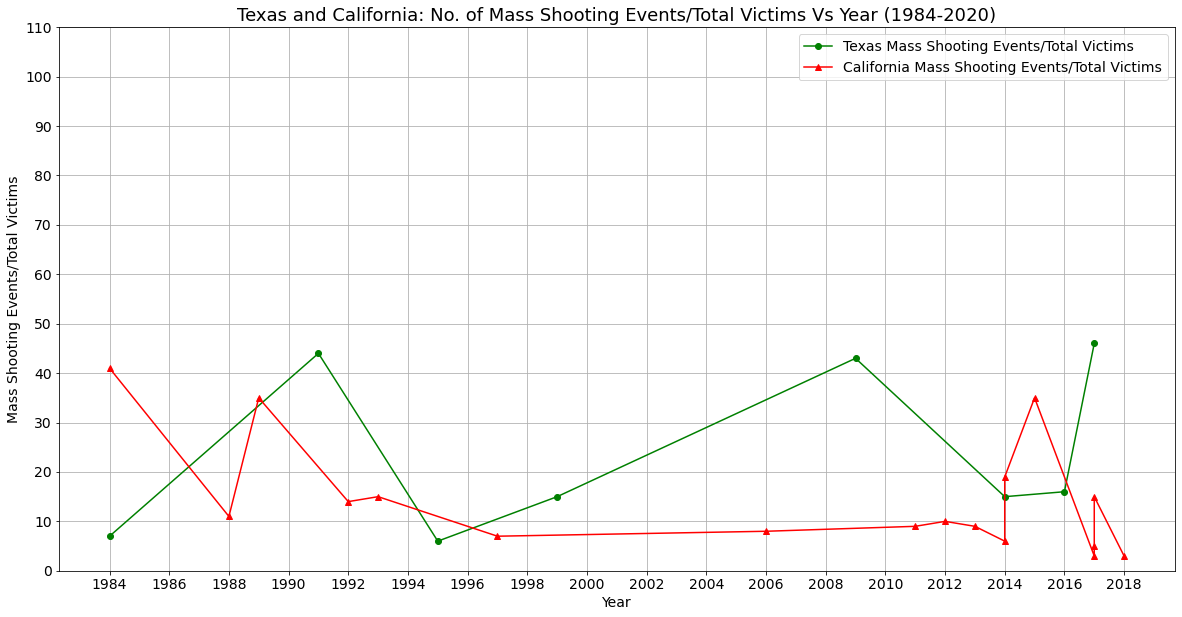

In [192]:
# Plot mass shootings for California and Texas vs year
plt.figure(figsize = (20, 10))
plt.plot(x_tex_mass, y_tex_mass, marker = 'o', color = "green", label = 'Texas Mass Shooting Events/Total Victims')
plt.plot(x_cal_mass, y_cal_mass, marker = '^', color = "red", label = 'California Mass Shooting Events/Total Victims')
plt.title('Texas and California: No. of Mass Shooting Events/Total Victims Vs Year (1984-2020)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Mass Shooting Events/Total Victims', fontsize = 14)
plt.xticks(np.arange(1984, 2020, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 120, step = 10), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()
plt.savefig('output_data/Texas_Cal_mass_shooting.png')
plt.show()

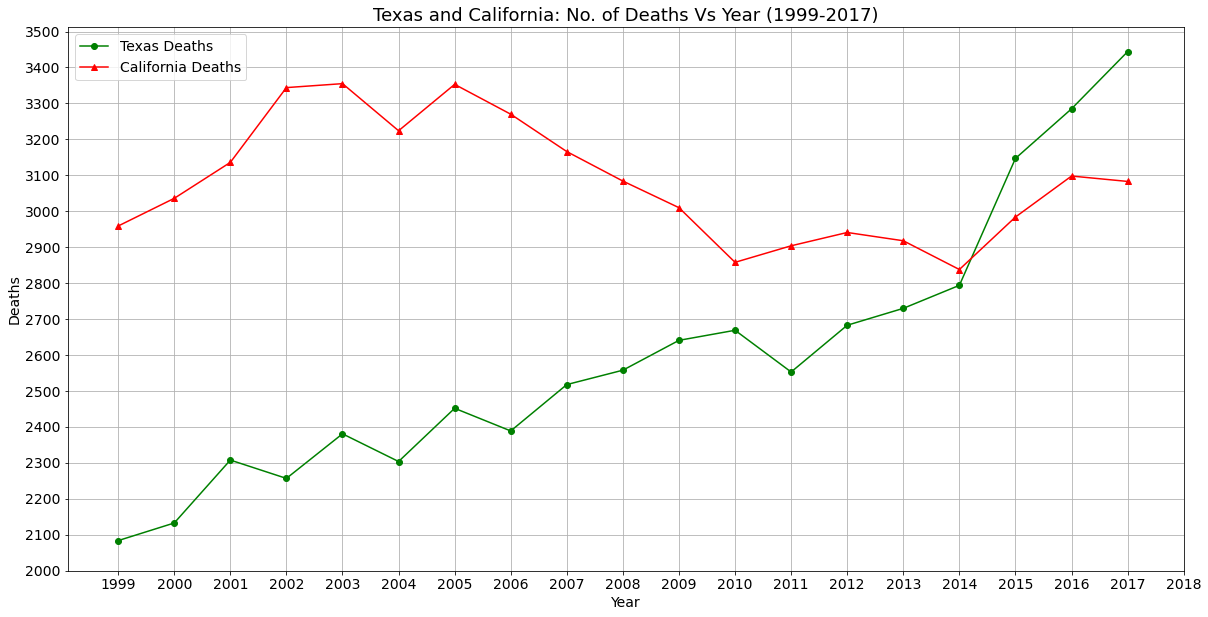

In [190]:
# Plot California and Texas deaths vs year
plt.figure(figsize = (20, 10))
plt.plot(pop_years, tex_deaths, marker = 'o', color = "green", label = 'Texas Deaths')
plt.plot(pop_years, cal_deaths, marker = '^', color = "red", label = 'California Deaths')
plt.title('Texas and California: No. of Deaths Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Deaths', fontsize = 14)
plt.xticks(np.arange(1999, 2019, step = 1), fontsize = 14)
plt.yticks(np.arange(2000, 3600, step = 100), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()
plt.savefig('output_data/cal_tex_deaths.png')
plt.show()

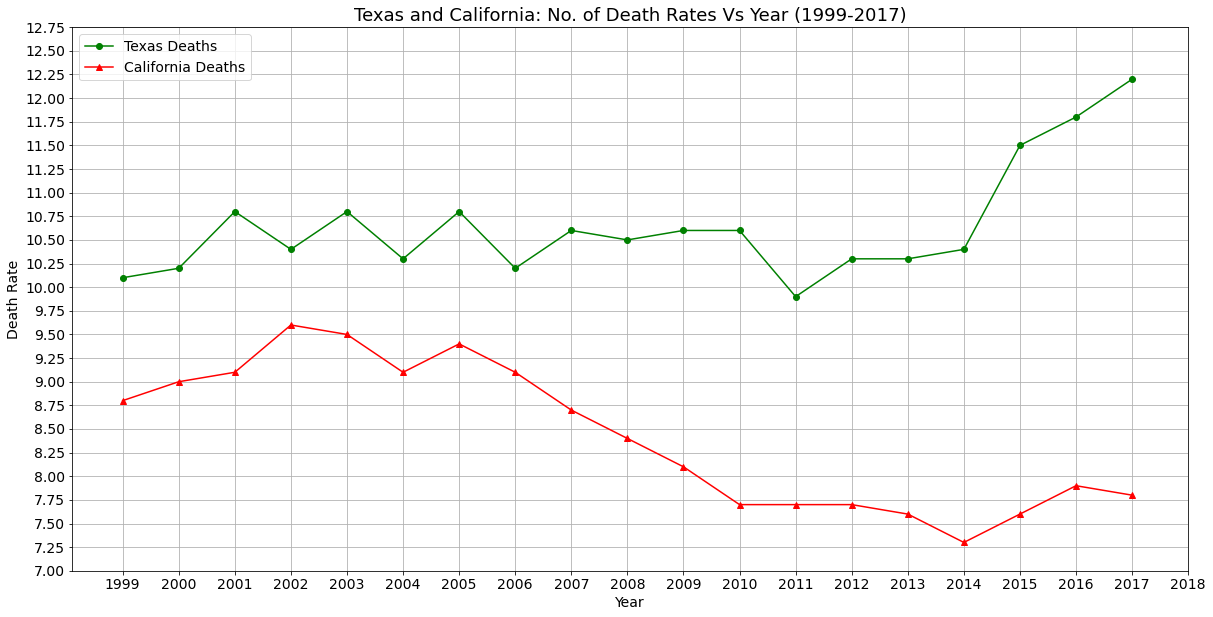

In [189]:
# Plot California and Texas death rates vs year
plt.figure(figsize = (20, 10))
plt.plot(pop_years, tex_death_rate, marker = 'o', color = "green", label = 'Texas Deaths')
plt.plot(pop_years, cal_death_rate, marker = '^', color = "red", label = 'California Deaths')
plt.title('Texas and California: No. of Death Rates Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Death Rate', fontsize = 14)
plt.xticks(np.arange(1999, 2019, step = 1), fontsize = 14)
plt.yticks(np.arange(7, 13, step = 0.25), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()
plt.savefig('output_data/cal_tex_death_rate.png')
plt.show()

Ttest_indResult(statistic=14.775279563643117, pvalue=1.6589647964673424e-11)

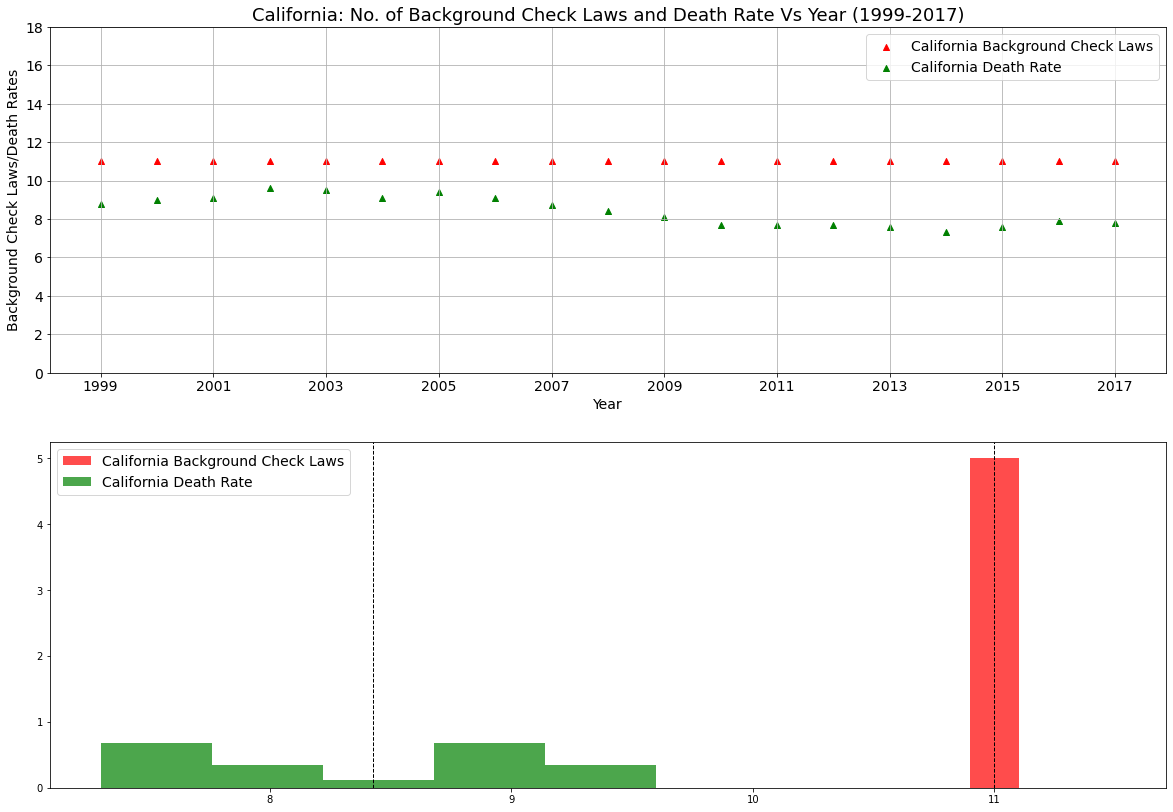

In [217]:
# T-test: California background check laws and death rates vs year
# Scatter Plot of Data
plt.figure(figsize = (20, 14))

plt.subplot(2, 1, 1)
plt.scatter(pop_years, y_cal_bgck, marker = '^', color = "red", label = 'California Background Check Laws')
plt.scatter(pop_years, cal_death_rate, marker = '^', color = "green", label = 'California Death Rate')
plt.title('California: No. of Background Check Laws and Death Rate Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Background Check Laws/Death Rates', fontsize = 14)
plt.xticks(np.arange(1999, 2018, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 20, step = 2), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()    

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(y_cal_bgck, 5, density=True, alpha=0.7, color = "red", label = 'California Background Check Laws')
plt.hist(cal_death_rate, 5, density=True, alpha=0.7, color = "green", label = 'California Death Rate')
plt.axvline(y_cal_bgck.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(cal_death_rate.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend(loc = 'best', fontsize = 14)
plt.savefig('output_data/cal_bgck_death_hist.png')
    
# T-test
stats.ttest_ind(y_cal_bgck, cal_death_rate, equal_var=False)

Ttest_indResult(statistic=-78.40273902091246, pvalue=2.863570537025594e-24)

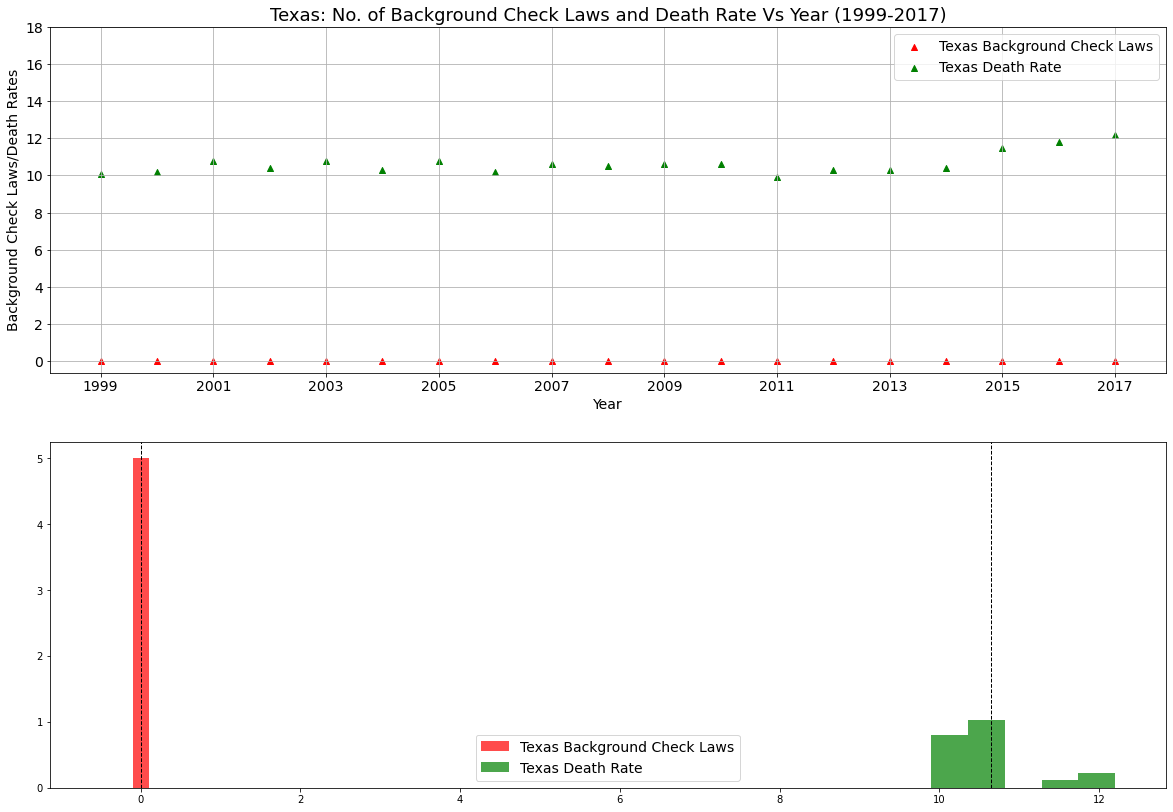

In [215]:
# T-test: Texas background check laws and death rates vs year
# Scatter Plot of Data
plt.figure(figsize = (20, 14))

plt.subplot(2, 1, 1)
plt.scatter(pop_years, y_tex_bgck, marker = '^', color = "red", label = 'Texas Background Check Laws')
plt.scatter(pop_years, tex_death_rate, marker = '^', color = "green", label = 'Texas Death Rate')
plt.title('Texas: No. of Background Check Laws and Death Rate Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Background Check Laws/Death Rates', fontsize = 14)
plt.xticks(np.arange(1999, 2018, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 20, step = 2), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()    

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(y_tex_bgck, 5, density=True, alpha=0.7, color = "red", label = 'Texas Background Check Laws')
plt.hist(tex_death_rate, 5, density=True, alpha=0.7, color = "green", label = 'Texas Death Rate')
plt.axvline(y_tex_bgck.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tex_death_rate.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend(loc = 'best', fontsize = 14)
plt.savefig('output_data/tex_bgck_death_hist.png')
    
# T-test
stats.ttest_ind(y_tex_bgck, tex_death_rate, equal_var=False)

Ttest_indResult(statistic=48.379697723448416, pvalue=8.13108890615216e-21)

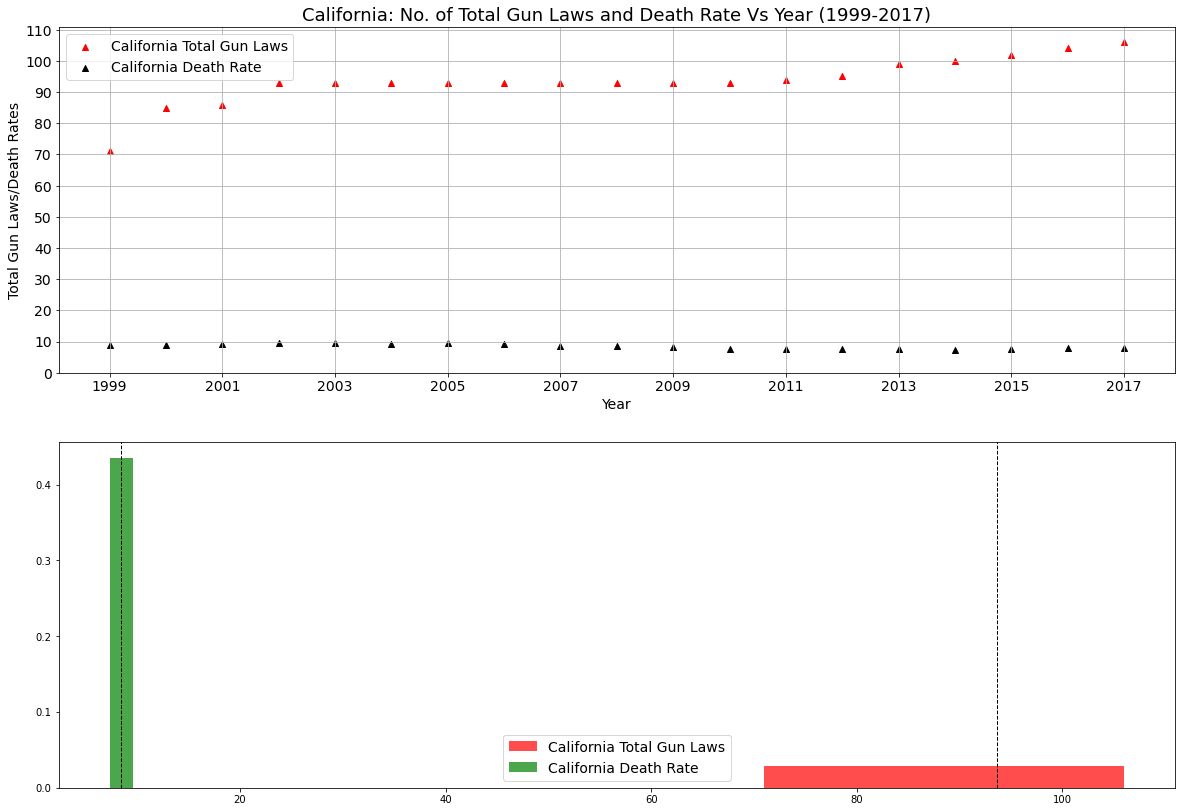

In [219]:
# T-test: California total gun laws and death rates vs year
# Scatter plot
plt.figure(figsize = (20, 14))

plt.subplot(2, 1, 1)
plt.scatter(pop_years, y_cal_laws, marker = '^', color = "red", label = 'California Total Gun Laws')
plt.scatter(pop_years, cal_death_rate, marker = '^', color = "black", label = 'California Death Rate')
plt.title('California: No. of Total Gun Laws and Death Rate Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Total Gun Laws/Death Rates', fontsize = 14)
plt.xticks(np.arange(1999, 2018, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 120, step = 10), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()    

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(y_cal_laws, 1, density=True, alpha=0.7, color = "red", label = 'California Total Gun Laws')
plt.hist(cal_death_rate, 1, density=True, alpha=0.7, color = "green", label = 'California Death Rate')
plt.axvline(y_cal_laws.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(cal_death_rate.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend(loc = 'best', fontsize = 14)
plt.savefig('output_data/cal_totlaw_death_hist.png')
    
# T-test
stats.ttest_ind(y_cal_laws, cal_death_rate, equal_var=False)

Ttest_indResult(statistic=20.142573835226596, pvalue=4.1925413815982604e-16)

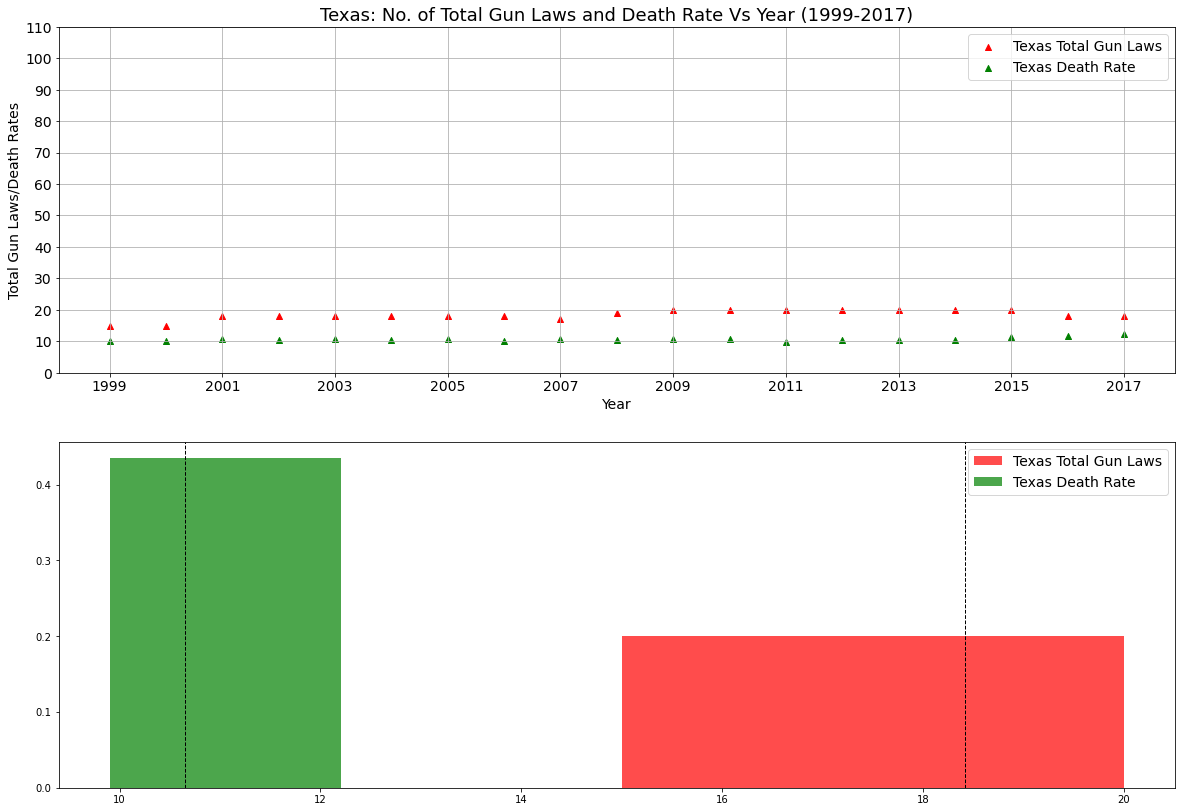

In [220]:
# T-test: Texas total gun laws and death rates vs year
# Scatter plot
plt.figure(figsize = (20, 14))

plt.subplot(2, 1, 1)
plt.scatter(pop_years, y_tex_laws, marker = '^', color = "red", label = 'Texas Total Gun Laws')
plt.scatter(pop_years, tex_death_rate, marker = '^', color = "green", label = 'Texas Death Rate')
plt.title('Texas: No. of Total Gun Laws and Death Rate Vs Year (1999-2017)', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Total Gun Laws/Death Rates', fontsize = 14)
plt.xticks(np.arange(1999, 2018, step = 2), fontsize = 14)
plt.yticks(np.arange(0, 120, step = 10), fontsize = 14)
plt.legend(loc = 'best', fontsize = 14)
plt.grid()    

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(y_tex_laws, 1, density=True, alpha=0.7, color = "red", label = 'Texas Total Gun Laws')
plt.hist(tex_death_rate, 1, density=True, alpha=0.7, color = "green", label = 'Texas Death Rate')
plt.axvline(y_tex_laws.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tex_death_rate.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend(loc = 'best', fontsize = 14)
plt.savefig('output_data/tex_totlaw_death_hist.png')
    
# T-test
stats.ttest_ind(y_tex_laws, tex_death_rate, equal_var=False)

In [153]:
# T-test: California and Texas background check laws and deaths vs year

In [154]:
# T-test: California and Texas total gun laws and deaths vs year

In [14]:
data_df2.head()

state  year  backgroundchecktotal  lawtotal
0     Alabama  1991                     0        15
1      Alaska  1991                     0        10
2     Arizona  1991                     0        12
3    Arkansas  1991                     0        15
4  California  1991                    11        58

In [15]:
tex_laws = data_df2.loc[data_df2['state'] == 'Texas']
tex_laws = tex_laws.rename(columns={'state': 'State', 'year': 'Year', 'backgroundchecktotal': 'Total Background Laws', 'lawtotal': 'Total Guns Laws'})
tex_laws.head()

State  Year  Total Background Laws  Total Guns Laws
42   Texas  1991                      0               13
92   Texas  1992                      0               13
142  Texas  1993                      0               12
192  Texas  1994                      0               13
242  Texas  1995                      0               15

In [16]:
tex_death_df.head()

State  Year  Deaths  Population  Crude Rate
0  Texas  1999    2084    20558220        10.1
1  Texas  2000    2133    20851820        10.2
2  Texas  2001    2308    21319622        10.8
3  Texas  2002    2257    21690325        10.4
4  Texas  2003    2381    22030931        10.8

In [22]:
tex_comp_data = pd.merge(tex_death_df, tex_laws, how='left', on=['Year', 'State'])
tex_comp_data = tex_comp_data.dropna()
tex_comp_data['Deaths Percent'] = round((tex_comp_data['Deaths']/tex_comp_data['Population'])*100, 3)
tex_comp_data.to_csv('Resources/tex_comp_data.csv', index=False)
tex_comp_data.tail()

State  Year  Deaths  Population  Crude Rate  Total Background Laws  \
14  Texas  2013    2730    26448193        10.3                    0.0   
15  Texas  2014    2794    26956958        10.4                    0.0   
16  Texas  2015    3147    27469114        11.5                    0.0   
17  Texas  2016    3285    27862596        11.8                    0.0   
18  Texas  2017    3444    28304596        12.2                    0.0   

    Total Guns Laws  Deaths Percent  
14             20.0           0.010  
15             20.0           0.010  
16             20.0           0.011  
17             18.0           0.012  
18             18.0           0.012

In [18]:
cal_laws = data_df2.loc[data_df2['state'] == 'California']
cal_laws = cal_laws.rename(columns={'state': 'State', 'year': 'Year', 'backgroundchecktotal': 'Total Background Laws', 'lawtotal': 'Total Guns Laws'})
cal_laws.head()
# cal_laws.tail()

State  Year  Total Background Laws  Total Guns Laws
4    California  1991                     11               58
54   California  1992                     11               57
104  California  1993                     11               57
154  California  1994                     11               69
204  California  1995                     11               69

In [19]:
cal_death_df.head()

State  Year  Deaths  Population  Crude Rate
0  California  1999    2959    33499204         8.8
1  California  2000    3036    33871648         9.0
2  California  2001    3136    34479458         9.1
3  California  2002    3344    34871843         9.6
4  California  2003    3355    35253159         9.5

In [20]:
tex_comp_data.tail()

State  Year  Deaths  Population  Crude Rate  Total Background Laws  \
14  Texas  2013    2730    26448193        10.3                    0.0   
15  Texas  2014    2794    26956958        10.4                    0.0   
16  Texas  2015    3147    27469114        11.5                    0.0   
17  Texas  2016    3285    27862596        11.8                    0.0   
18  Texas  2017    3444    28304596        12.2                    0.0   

    Total Guns Laws  Deaths Percent  
14             20.0           0.010  
15             20.0           0.010  
16             20.0           0.011  
17             18.0           0.012  
18             18.0           0.012

In [23]:
cal_comp_data = pd.merge(cal_death_df, cal_laws, how='left', on=['Year', 'State'])
cal_comp_data = cal_comp_data.dropna()
cal_comp_data['Deaths Percent'] = round((cal_comp_data['Deaths']/cal_comp_data['Population'])*100, 3)
cal_comp_data.to_csv('Resources/cal_comp_data.csv', index=False)
cal_comp_data.tail()

State  Year  Deaths  Population  Crude Rate  Total Background Laws  \
14  California  2013    2918    38332521         7.6                   11.0   
15  California  2014    2838    38802500         7.3                   11.0   
16  California  2015    2984    39144818         7.6                   11.0   
17  California  2016    3098    39250017         7.9                   11.0   
18  California  2017    3083    39536653         7.8                   11.0   

    Total Guns Laws  Deaths Percent  
14             99.0           0.008  
15            100.0           0.007  
16            102.0           0.008  
17            104.0           0.008  
18            106.0           0.008